In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from lifelines import CoxPHFitter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
df = pd.read_csv("../data/intermediate/aggregated.csv")

In [3]:
df.head(3)

,gov_id,country_name,country_region,country_continent,gov_leader,regime_is_democracy,regime_type,gov_start,gov_duration,gov_observed_regular_end,...,sum_crisis_systemic,sum_default_domestic_debt,sum_default_sovereign_debt_tp2,sum_crisis_currency,last_ref_inflation,pond_crisis_banking,pond_crisis_systemic,pond_default_domestic_debt,pond_default_sovereign_debt_tp2,pond_crisis_currency
0,AHMED BEN BELLA,ALGERIA,Northern Africa,Africa,AHMED BEN BELLA,False,Civilian Dict,1962,3,True,...,0,0,0,0,NaN,0.000000,0.000000,0.0,0.000000,0.000000
1,HOUARI BOUMEDIENNE,ALGERIA,Northern Africa,Africa,HOUARI BOUMEDIENNE,False,Military Dict,1965,13,False,...,0,0,0,0,11.450379,0.000000,0.000000,0.0,0.000000,0.000000
2,BENJEDID CHADLI,ALGERIA,Northern Africa,Africa,BENJEDID CHADLI,False,Military Dict,1979,13,True,...,2,0,1,4,25.900000,0.274725,0.274725,0.0,0.142857,0.064485


### Construindo pipeline

Vamos realizar as seguintes transformações no dado:
1. Aplicar OneHotEncoding nas colunas categóricas
3. Aplicar KNN Inputer para preencher valores faltantes em `last_ref_inflation`
4. Aplicar StandardScaler para normalizar valores em `last_ref_inflation`

In [113]:
df.columns

Index(['gov_id', 'country_name', 'country_region', 'country_continent',
       'gov_leader', 'regime_is_democracy', 'regime_type', 'gov_start',
       'gov_duration', 'gov_observed_regular_end', 'gov_observed_death',
       'sum_crisis_banking', 'sum_crisis_systemic',
       'sum_default_domestic_debt', 'sum_default_sovereign_debt_tp2',
       'sum_crisis_currency', 'last_ref_inflation', 'pond_crisis_banking',
       'pond_crisis_systemic', 'pond_default_domestic_debt',
       'pond_default_sovereign_debt_tp2', 'pond_crisis_currency'],
      dtype='object')

In [4]:
cols_to_use = [
        "country_region", "regime_type", 'sum_crisis_banking',
       'sum_crisis_systemic', 'sum_default_domestic_debt',
       'sum_default_sovereign_debt_tp2', 'sum_crisis_currency',
       'last_ref_inflation', 'pond_crisis_banking', 'pond_crisis_systemic',
       'pond_default_domestic_debt', 'pond_default_sovereign_debt_tp2',
       'pond_crisis_currency', 'gov_observed_death', 'gov_duration'
]

In [103]:
def eval_model(df, cols_to_use):

    # SPLITTING DATA
    cols_to_use = cols_to_use + ['gov_observed_death', 'gov_duration']
    cols_to_encode = [col for col in df.columns[df.dtypes == object] if col in cols_to_use]
    X_train, X_test = train_test_split(df[cols_to_use])

    # PREPARING DATA
    transformations = []

    if "last_ref_inflation" in cols_to_use:
        num_mis_pipe = Pipeline([
            ("imputer", KNNImputer()),
            ("scaler", StandardScaler())
        ])
        transformations.append(
            ("imp_disc", num_mis_pipe, ["last_ref_inflation"])
        )
    transformations.append(
        ("encoder", OneHotEncoder(drop="first"), cols_to_encode)
    )

    preprocesser = ColumnTransformer(transformations, remainder="passthrough")

    try:
        X_train = preprocesser.fit_transform(X_train)
        X_test = preprocesser.fit_transform(X_test)
        if not isinstance(X_train, np.ndarray): # IN CASE OF SPARSE MATRIX
            X_train = X_train.toarray()
        if not isinstance(X_test, np.ndarray):
            X_test = X_test.toarray()

        X_train = pd.DataFrame(
            X_train, 
            columns=preprocesser.get_feature_names_out()
        )
        X_test = pd.DataFrame(
            X_test, 
            columns=preprocesser.get_feature_names_out()
        )

        # EVALUATING MODEL
        cph = CoxPHFitter()
        cph.fit(X_train, event_col="remainder__gov_observed_death", duration_col="remainder__gov_duration")

        return cols_to_use, cph, cph.score(X_test, scoring_method="concordance_index")
    except ValueError:
        return None

### Escolha do modelo

Para a avaliação do modelo, geraremos combinações de alguns conjuntos de variáveis e escolheremos a que tem o maior índice de concordância. A solução não considerará todas as combinações de features possíveis por razões naturais (isso exigiria um grande esforço computacional), e, ao mesmo tempo, também não usa grid search, cross validation e técnicas mais inteligentes de escolha de features, em grande parte devido à ainda bastante pobre compatibilidade entre *lifelines* e *scikit-learn*.

In [68]:
combinations_cols = [
    x for x in df.columns 
    if x not in ['gov_id', 'gov_leader', 'country_name', 'gov_start', 'gov_duration', 'gov_observed_regular_end', 'gov_observed_death']
]

combinations_cols = (
    [[x] for x in combinations_cols if not x.startswith("sum_") and not x.startswith("pond_")] + 
    [[x for x in combinations_cols if x.startswith("sum_")]] +
    [[x for x in combinations_cols if x.startswith("pond_")]]
)

In [7]:
from itertools import chain, combinations

In [69]:
generated_combinations = []

def all_subsets(ss):
    return chain(*map(lambda x: combinations(ss, x), range(4, len(ss) + 1)))

for subset in all_subsets(combinations_cols):
    generated_combinations.append(subset)

In [70]:
generated_combinations = [sum(comb, []) for comb in generated_combinations]

In [72]:
generated_combinations = [x for x in generated_combinations if not ("country_region" in x and "country_continent" in x)]
generated_combinations = [x for x in generated_combinations if not ("regime_is_democracy" in x and "regime_type" in x)]

In [73]:
evaluated_models = [eval_model(df, comb) for comb in generated_combinations]

/home/marcel/repos/survival-regimes/.venv/lib/python3.8/site-packages/lifelines/utils/__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/home/marcel/repos/survival-regimes/.venv/lib/python3.8/site-packages/lifelines/utils/__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/home/marcel/repos/survival-regimes/.venv/lib/python3.8/site-packages/lifelines/utils/__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnin

In [74]:
evaluated_models = [x for x in evaluated_models if x is not None]

In [75]:
best_model = 0
for i in range(len(evaluated_models)):
    if evaluated_models[i][2] > evaluated_models[best_model][2]:
        best_model = i

In [76]:
choosed_model = evaluated_models[best_model]

O melhor modelo usa as seguintes features:

In [77]:
choosed_model[0]

['country_region',
 'regime_type',
 'last_ref_inflation',
 'sum_crisis_banking',
 'sum_crisis_systemic',
 'sum_default_domestic_debt',
 'sum_default_sovereign_debt_tp2',
 'sum_crisis_currency',
 'pond_crisis_banking',
 'pond_crisis_systemic',
 'pond_default_domestic_debt',
 'pond_default_sovereign_debt_tp2',
 'pond_crisis_currency',
 'gov_observed_death',
 'gov_duration']

Nos dados de teste, ele alcança o seguinte índice de concordância:

In [78]:
choosed_model[2]

0.811530984780238

Por fim, aqui está uma visão geral do modelo e das estimativas de coeficientes:

In [79]:
choosed_model[1].print_summary()

/home/marcel/repos/survival-regimes/.venv/lib/python3.8/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 690 total observations, 48 right-censored observations>
             duration col = 'remainder__gov_duration'
                event col = 'remainder__gov_observed_death'
      baseline estimation = breslow
   number of observations = 690
number of events observed = 642
   partial log-likelihood = -3356.81
         time fit was run = 2022-06-04 21:03:00 UTC

---
                                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                          
imp_disc__last_ref_inflation                -0.01       0.99       0.04            -0.09             0.07                 0.92                 1.08
encoder__country_region_Caribbean            0.37       1.44       0.48            -0.58             1.31                 0.56                 3.71
encoder__country_region_Central America      0.33       1.40       0.33            -0.30             0.97                 0.74                 2.64
encoder__country_region_Eastern Africa      -0.15       0.86       0.38            -0.90             0.60                 0.41                 1.81
encoder__country_region_Eastern Asia         0.64       1.90       0.33             0.00             1.29                 1.00                 3.62
encoder__country_region_Eastern Europe       0.17       1.19       0.35            -0.51             0.86                 0.60                 2.37
encoder__country_region_Middle Africa       -0.08       0.92       0.48            -1.02             0.85                 0.36                 2.34
encoder__country_region_Northern Africa     -0.60       0.55       0.48            -1.54             0.34                 0.21                 1.41
encoder__country_region_Northern America    -0.38       0.68       0.45            -1.27             0.51                 0.28                 1.66
encoder__country_region_Northern Europe      0.04       1.04       0.28            -0.51             0.60                 0.60                 1.82
encoder__country_region_South America        0.81       2.26       0.32             0.19             1.44                 1.21                 4.22
encoder__country_region_South-Eastern Asia  -0.08       0.92       0.33            -0.72             0.57                 0.48                 1.77
encoder__country_region_Southern Africa      0.06       1.06       0.51            -0.94             1.06                 0.39                 2.88
encoder__country_region_Southern Asia        0.24       1.27       0.34            -0.43             0.90                 0.65                 2.47
encoder__country_region_Southern Europe      0.39       1.48       0.29            -0.17             0.95                 0.84                 2.59
encoder__country_region_Western Africa       0.58       1.78       0.37            -0.16             1.31                 0.85                 3.70
encoder__country_region_Western Asia         0.56       1.75       0.37            -0.17             1.29                 0.85                 3.63
encoder__country_region_Western Europe       0.19       1.20       0.28            -0.37             0.74                 0.69                 2.09
encoder__regime_type_Military Dict           0.17       1.18       0.19            -0.20             0.54                 0.82                 1.71
encoder__regime_type_Mixed Dem               0.65       1.91       0.21             0.24             1.05                 1.27                 2.86
encoder__regime_type_Monarchy               -1.30       0.27       1.21            -3.67             1.07                 0.03                 2.92
encoder__regime_type_Parliamentary Dem       0.47       1.60       0.18             0.11             0.83                 1.12                 2.29
encoder__regime_type_Presidential Dem        0.1

<AxesSubplot:xlabel='log(HR) (95% CI)'>

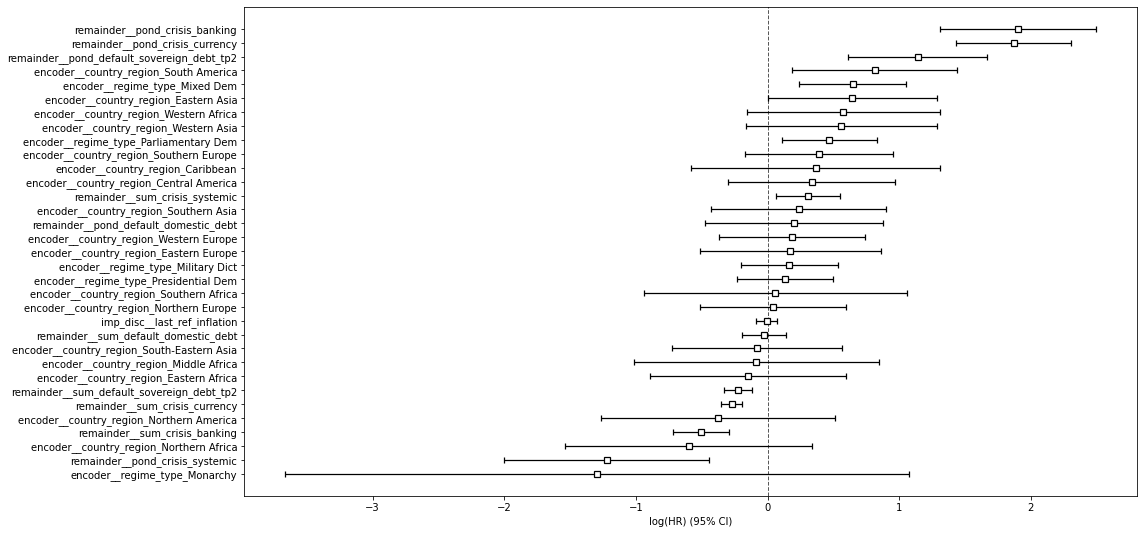

In [80]:
fig, ax = plt.subplots(figsize=(16, 9))

choosed_model[1].plot()

Ainda não testamos se faz sentido incluir todas as combinações de variáveis agregadas (**remainder__pond** e **remainder__sum**).

In [81]:
combinations_cols_agg = [
    'sum_crisis_banking','sum_crisis_systemic','sum_default_domestic_debt','sum_default_sovereign_debt_tp2','sum_crisis_currency',
    'pond_crisis_banking', 'pond_crisis_systemic','pond_default_domestic_debt','pond_default_sovereign_debt_tp2','pond_crisis_currency'
]

In [100]:
generated_combinations_agg = []

def all_subsets(ss):
    return chain(*map(lambda x: combinations(ss, x), range(2, len(ss) + 1)))

for subset in all_subsets(combinations_cols_agg):
    generated_combinations_agg.append(subset)

In [101]:
generated_combinations_agg = [
    list(x) + ['regime_type', 'country_region', 'last_ref_inflation'] 
    for x in generated_combinations_agg
]

In [104]:
evaluated_models_agg = [eval_model(df, comb) for comb in generated_combinations_agg]

/home/marcel/repos/survival-regimes/.venv/lib/python3.8/site-packages/lifelines/utils/__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/home/marcel/repos/survival-regimes/.venv/lib/python3.8/site-packages/lifelines/utils/__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/home/marcel/repos/survival-regimes/.venv/lib/python3.8/site-packages/lifelines/utils/__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnin

In [105]:
evaluated_models_agg = [x for x in evaluated_models_agg if x is not None]

In [106]:
best_model = 0
for i in range(len(evaluated_models_agg)):
    if evaluated_models_agg[i][2] > evaluated_models_agg[best_model][2]:
        best_model = i

In [107]:
best_model

552

In [108]:
evaluated_models_agg[best_model]

(['sum_crisis_banking',
  'sum_crisis_systemic',
  'sum_default_domestic_debt',
  'sum_default_sovereign_debt_tp2',
  'sum_crisis_currency',
  'pond_crisis_banking',
  'pond_default_domestic_debt',
  'pond_default_sovereign_debt_tp2',
  'pond_crisis_currency',
  'regime_type',
  'country_region',
  'last_ref_inflation',
  'gov_observed_death',
  'gov_duration'],
 <lifelines.CoxPHFitter: fitted with 690 total observations, 50 right-censored observations>,
 0.8039599236641222)

In [109]:
evaluated_models_agg[best_model][1].print_summary()

/home/marcel/repos/survival-regimes/.venv/lib/python3.8/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 690 total observations, 50 right-censored observations>
             duration col = 'remainder__gov_duration'
                event col = 'remainder__gov_observed_death'
      baseline estimation = breslow
   number of observations = 690
number of events observed = 640
   partial log-likelihood = -3346.51
         time fit was run = 2022-06-04 23:13:39 UTC

---
                                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                          
imp_disc__last_ref_inflation                 0.02       1.02       0.04            -0.06             0.09                 0.94                 1.10
encoder__country_region_Caribbean            0.09       1.09       0.49            -0.88             1.06                 0.42                 2.87
encoder__country_region_Central America      0.29       1.33       0.33            -0.35             0.93                 0.70                 2.53
encoder__country_region_Eastern Africa      -0.24       0.79       0.40            -1.03             0.55                 0.36                 1.74
encoder__country_region_Eastern Asia         0.39       1.48       0.31            -0.22             1.00                 0.80                 2.71
encoder__country_region_Eastern Europe      -0.02       0.98       0.35            -0.70             0.66                 0.50                 1.94
encoder__country_region_Middle Africa        0.09       1.09       0.49            -0.87             1.05                 0.42                 2.85
encoder__country_region_Northern Africa     -0.28       0.75       0.49            -1.24             0.67                 0.29                 1.95
encoder__country_region_Northern America    -0.56       0.57       0.43            -1.41             0.29                 0.24                 1.33
encoder__country_region_Northern Europe     -0.01       0.99       0.28            -0.56             0.54                 0.57                 1.71
encoder__country_region_South America        0.67       1.94       0.32             0.04             1.29                 1.05                 3.62
encoder__country_region_South-Eastern Asia  -0.21       0.81       0.34            -0.87             0.45                 0.42                 1.56
encoder__country_region_Southern Africa      0.12       1.13       0.47            -0.80             1.04                 0.45                 2.83
encoder__country_region_Southern Asia        0.07       1.07       0.34            -0.59             0.72                 0.55                 2.06
encoder__country_region_Southern Europe      0.29       1.34       0.29            -0.26             0.85                 0.77                 2.35
encoder__country_region_Western Africa       0.23       1.26       0.38            -0.51             0.97                 0.60                 2.64
encoder__country_region_Western Asia         0.56       1.75       0.36            -0.14             1.26                 0.87                 3.52
encoder__country_region_Western Europe       0.21       1.24       0.28            -0.34             0.76                 0.72                 2.14
encoder__regime_type_Military Dict           0.12       1.12       0.18            -0.24             0.48                 0.78                 1.61
encoder__regime_type_Mixed Dem               0.54       1.72       0.21             0.12             0.96                 1.13                 2.61
encoder__regime_type_Monarchy               -1.74       0.18       1.16            -4.01             0.52                 0.02                 1.69
encoder__regime_type_Parliamentary Dem       0.50       1.65       0.19             0.12             0.88                 1.13                 2.40
encoder__regime_type_Presidential Dem        0.0

<AxesSubplot:xlabel='log(HR) (95% CI)'>

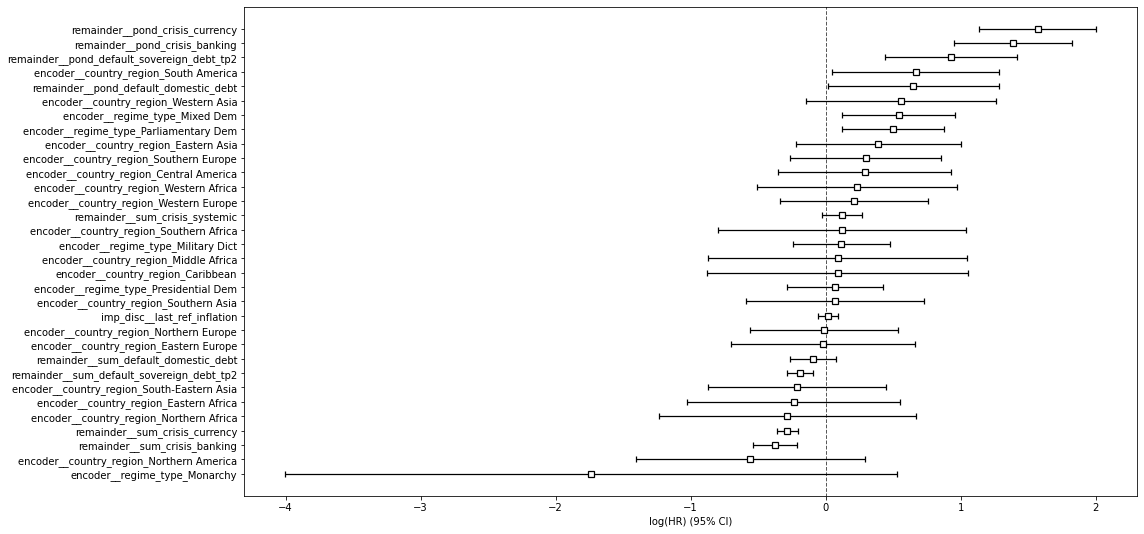

In [111]:
fig, ax = plt.subplots(figsize=(16, 9))

evaluated_models_agg[best_model][1].plot()